# Overview

# Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# Learning Objectives
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 

# Contents
- [Data Loading](#data-loading)
- [Determine Level of EHR](#determine-level-of-EHR)
- [EDA](#eda)
- [Reduce Dimensionality of the NDC Code Feature](#reduce-dimensionality-of-the-ndc-code-feature)
- [Select First Encounter for each Patient](#select-first-encounter-for-each-patient)
- [Aggregate Dataset](#aggregate-dataset)
- [Prepare Fields and Cast Dataset](#prepare-fields-and-cast-dataset)
- [Split Dataset](#split-dataset)
- [Create Features with TF Feature Columns](#create-features-with-tf-feature-columns)
- [Build Model](#build-model)
- [Process Model's Prediction Outputs](#process-model's-prediction-outputs)
- [Model Evaluation Metrics](#model-evaluation-metrics)
- [Evaluating Potential Model Biases with Aequitas Toolkit](#evaluating-potential-model-biases-with-aequitas-toolkit)

In [1]:
import student_utils as stu
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
sns.set_style('darkgrid')

pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
%reload_ext autoreload

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data Loading

TThe dataset is located at the following path `./data/final_project_dataset.csv`. Also, review the information found in the data schema `./data_schema_references`/ for the EDA.

In [4]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [5]:
# Conver the `payer_code_bin` into binary to distinguish self-pay (SP) from 
# patients with other paying options.
df['payer_code_bin'] = df['payer_code'].apply(lambda x: 1. if x=='SP' else 0.)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   encounter_id              143424 non-null  int64  
 1   patient_nbr               143424 non-null  int64  
 2   race                      143424 non-null  object 
 3   gender                    143424 non-null  object 
 4   age                       143424 non-null  object 
 5   weight                    143424 non-null  object 
 6   admission_type_id         143424 non-null  int64  
 7   discharge_disposition_id  143424 non-null  int64  
 8   admission_source_id       143424 non-null  int64  
 9   time_in_hospital          143424 non-null  int64  
 10  payer_code                143424 non-null  object 
 11  medical_specialty         143424 non-null  object 
 12  primary_diagnosis_code    143424 non-null  object 
 13  other_diagnosis_codes     143424 non-null  o

In [7]:
df.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,payer_code_bin
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,0.0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,0.0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,0.0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,0.0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0.0
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,0.0
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,0.0
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO,0.0
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO,0.0
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO,0.0


## Determine Level of EHR

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response: 
- EHR dataset could be at the line level because the number of rows is larger than the total amount of unique encounter_ids. 
- Additional field to aggregate on: `primary_diagnosis_code`

In [8]:
stu.df_level_test(df)

EHR dataset could be at the line level.


## EDA

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: 
- a. After checking the unique values and their amount in each column and comparing with other values in the column, I found three labels that may indicate a missing/outlier value: `[?, Unknown/Invalid]`. These values may result from missing (completely) at random. For the sake of simplicity, I replaced data in this missing value list with `np.nan`. And based on the null value counts, `Weight`, `medical_specialty`, `payer_code`, and `ndc_code` have more than 20,000 missing values.  
- b. Based on the distribution plots, `num_medications` has a normal distribution. 
- c. Top 3 fields with high cardinality:
    * other_diagnosis_codes (19373)
    * primary_diagnosis_code (716)
    * ndc_code (251)
- d. Demographic distributions in the dataset:
    * Race: Caucasian (107,688) is the largest population within the dataset, which is follwed by African American (26427), and Hispanic (2938). Asian (888) is the smallest specified ethinic group represented in the dataset. The dataset consists of 888 records, whose race group is not identified. There are 3309 records with an invalid race entry. The dataset is heavily concentrated on Caucasian population. 
    * Age: The majority of the dataset are between 40-year-old to 90-year-old. Age group between 70-80 years' old is the most represented one in the dataset. The dataset focus on older people rather than middle ages or the youths. 
    * Gender: The gender ratio is about 1:1 (female to male), with relatively more female patients. There are 5 records that are associated with unknown/invalid gender information. This dataset represents female and male population quite comparably. 

In [9]:
# Check unique values in each column
for col in df.columns:
    print('{} consists the following unique values\n{}\n'.format(
        col, df[col].unique()))


encounter_id consists the following unique values
[  2278392    149190     64410 ... 443854148 443857166 443867222]

patient_nbr consists the following unique values
[  8222157  55629189  86047875 ... 140199494 120975314 175429310]

race consists the following unique values
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']

gender consists the following unique values
['Female' 'Male' 'Unknown/Invalid']

age consists the following unique values
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

weight consists the following unique values
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']

admission_type_id consists the following unique values
[6 1 2 3 4 5 8 7]

discharge_disposition_id consists the following unique values
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]

admission_source_id consists the following unique values
[ 1  7  2  4 

In [10]:
missing_vals_list = ['?', '?|?', 'Unknown/Invalid']


def rm_missingval(df, missing_vals_list=missing_vals_list):
    dfm = df.copy()
    dfm = dfm.replace(missing_vals_list, np.nan)
    dfm.head()
    return dfm


dfm = rm_missingval(df)


In [11]:
dfm.isnull().sum().sort_values(ascending=False)

weight                      139122
medical_specialty            69463
payer_code                   54190
ndc_code                     23462
race                          3309
other_diagnosis_codes          340
primary_diagnosis_code          33
gender                           5
patient_nbr                      0
age                              0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code_bin                   0
readmitted                       0
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
max_glu_serum                    0
A1Cresult                        0
change                           0
encounter_id                     0
dtype: int64

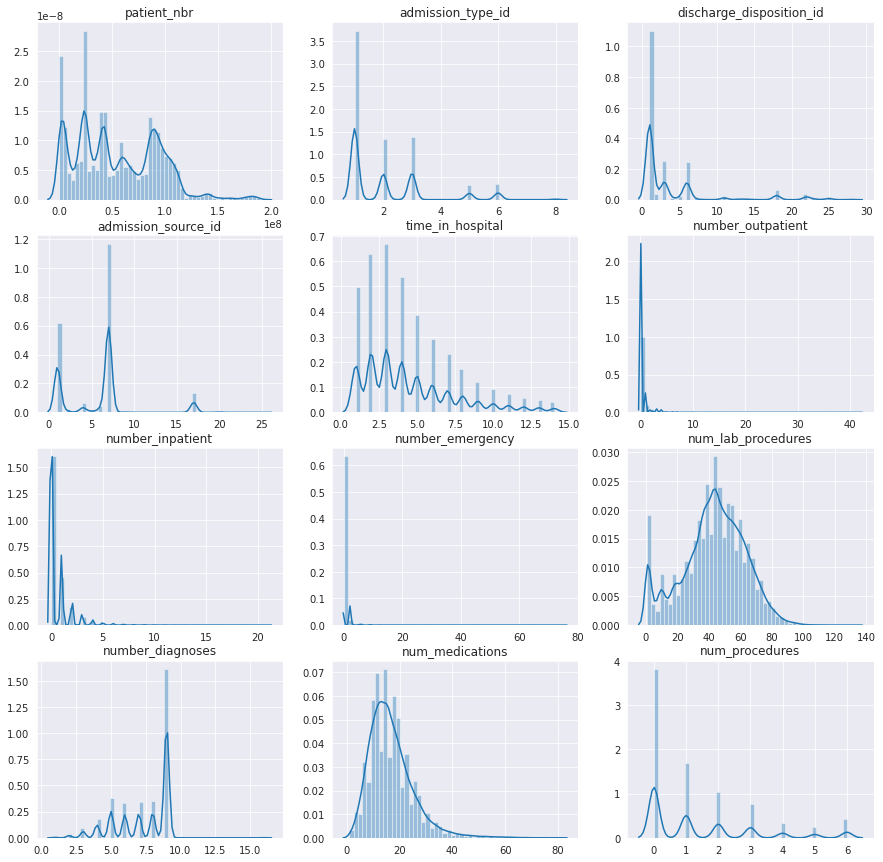

In [12]:
dfm_copy = dfm.copy()
del dfm_copy['encounter_id']
stu.num_col_dist(dfm_copy)

In [13]:
stu.cardinality_count(dfm, top=5)

,col_name,num_unique
9,other_diagnosis_codes,19373
8,primary_diagnosis_code,716
10,ndc_code,251
7,medical_specialty,72
4,discharge_disposition_id,26


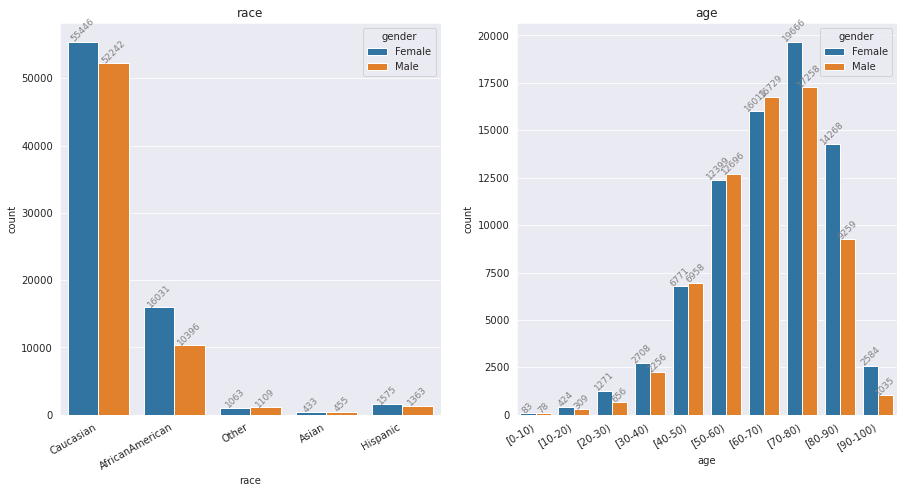

In [14]:
demographics = ['race', 'age']
stu.demo_plot(dfm, keys=demographics, rotation=45, save_fig=False)

In [15]:
df['race'].value_counts()

Caucasian          107688
AfricanAmerican     26427
?                    3309
Hispanic             2938
Other                2174
Asian                 888
Name: race, dtype: int64

In [16]:
df['age'].value_counts()

[70-80)     36928
[60-70)     32741
[50-60)     25095
[80-90)     23527
[40-50)     13729
[30-40)      4964
[90-100)     3619
[20-30)      1927
[10-20)       733
[0-10)        161
Name: age, dtype: int64

In [17]:
df['gender'].value_counts()

Female             76185
Male               67234
Unknown/Invalid        5
Name: gender, dtype: int64

In [18]:

# full_data_stats = tfdv.generate_statistics_from_csv(
#     data_location='./data/final_project_dataset.csv')
# tfdv.visualize_statistics(full_data_stats)


## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file `./data_schema_references/ndc_lookup_table.csv` derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [19]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [20]:
reduce_dim_df = stu.reduce_dimension_ndc(df, ndc_code_df)

The dimensionality of NDC_Code is reduced from 251 to 22.


In [21]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [22]:
first_encounter_df = stu.select_first_encounter(reduce_dim_df)


In [23]:
first_encounter_df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,payer_code_bin,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,0.0,Insulin Human
11,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,0.0,Glipizide
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,0.0,Human Insulin
13,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,0173-0863,None,None,Ch,NO,0.0,Rosiglitazone Maleate
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0.0,Glipizide


In [24]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()

# check if number of unique patients is equal to the number of unique encounters
# and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")


Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [ ]:
exclusion_list = ['generic_drug_name', 'ndc_code']
grouping_field_list = [
    c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(
    first_encounter_df, grouping_field_list, 'generic_drug_name')


Student response:     
The `weight` field should be dropped, as there are 97% of data missing and it will not provide us with much useful information.    
    While the missing rate for `payer_code` is 37.78%, this variable can be informative in predicting the the length of stay in hopspital where a patient is `self-pay` (SP). When a patient's in-hopital stay is not covered by insurance, it is less likely for the patient to stay for a long period of time. Thus, binarizing `payer_code` can be helpful in predicting the time in hospital. 

In [26]:
agg_drug_df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,payer_code_bin,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,0.0,"[Insulin Human, Glipizide]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,0.0,"[Human Insulin, Rosiglitazone Maleate]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,0.0,"[Glipizide, Human Insulin]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,0.0,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,0.0,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
len(agg_drug_df), len(df)


(71518, 143424)

In [28]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique(
) == agg_drug_df['encounter_id'].nunique()


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [29]:
rdf = reduce_dim_df.copy()
rdf = rdf.replace(missing_vals_list, np.nan)

In [30]:
missing_val_df = pd.DataFrame({'col_name': rdf.columns,
                               'counts_nan': rdf.isnull().sum(),
                               'percent_nan': round(100*rdf.isnull().sum()/len(rdf), 2)
                               })


In [31]:
missing_val_df = missing_val_df.reset_index(
    drop=True).sort_values('counts_nan', ascending=False)
missing_val_df.head(5)


,col_name,counts_nan,percent_nan
5,weight,139122,97.00
11,medical_specialty,69463,48.43
10,payer_code,54190,37.78
27,generic_drug_name,23462,16.36
21,ndc_code,23462,16.36


In [32]:
reduce_dim_df.weight.value_counts()


?            139122
[75-100)       1817
[50-75)        1133
[100-125)       890
[125-150)       200
[25-50)         118
[0-25)           67
[150-175)        55
[175-200)        18
>200              4
Name: weight, dtype: int64

In [33]:
reduce_dim_df.payer_code.value_counts()


?     54190
MC    46532
HM     8784
SP     7613
BC     6991
MD     4983
CP     3687
UN     3665
CM     2971
OG     1532
PO      919
DM      757
WC      230
CH      208
OT      160
MP      122
SI       79
FR        1
Name: payer_code, dtype: int64

In [34]:
DDM = [
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id',
    'primary_diagnosis_code',
    'other_diagnosis_codes',
    'change'
]


In [35]:
num = [
    'payer_code_bin',
    'num_lab_procedures',
    'number_diagnoses',
    'num_medications',
    'num_procedures'
]


In [36]:
'''
Please update the list to include the features you think are appropriate for the
model and the field that we will be using to train the model. There are three
required demographic features for the model and I have inserted a list with them
already in the categorical list. These will be required for later steps when
analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = DDM + required_demo_col_list + ndc_col_list
student_numerical_col_list = num
PREDICTOR_FIELD = 'time_in_hospital'


In [37]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + \
        categorical_col_list + numerical_col_list
    return agg_drug_df[selected_col_list]


In [38]:
selected_features_df = select_model_features(rdf, student_categorical_col_list, student_numerical_col_list,
                                             PREDICTOR_FIELD)


In [39]:
selected_features_df = selected_features_df.replace(missing_vals_list, np.nan)


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?    
**Answer**: some values may be missing not at random, and can be found back by interpreting the relationship between the missing data and the rest of the data in the dataset. This approach may lead to a unnecessarily reduced dataset size.  

In [40]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list,
                             student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)


In [41]:
processed_df.head()


,patient_nbr,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,other_diagnosis_codes,change,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,payer_code_bin,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,48330783,13.0,2,1,4,398,427|38,Ch,Caucasian,Female,[80-90),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,8,28,2
1,63555939,12.0,3,3,4,434,198|486,Ch,Caucasian,Female,[90-100),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33,8,18,3
2,42519267,1.0,1,1,7,197,157|250,Ch,Caucasian,Male,[40-50),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,5,8,0
3,89869032,9.0,1,1,7,250.7,403|996,No,AfricanAmerican,Female,[40-50),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,9,17,2
4,82637451,3.0,2,1,2,414,411|250,No,Caucasian,Male,[50-60),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,9,16,6


## Split Dataset

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [42]:
# from student_utils import patient_dataset_splitter
d_train, d_val, d_test = stu.patient_dataset_splitter(
    processed_df, 'patient_nbr')


Dataset is splited into train (42911, 60.00%), validation (14304, 20.00%), and test (14303, 20.00%)
Training partition has a shape =  (42911, 37)
Validation partition has a shape =  (14304, 37)
Test partition has a shape =  (14303, 37)
No overlapping among partitions.


In [43]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")


Test passed for number of total rows equal!


In [44]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() +
        d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")


Test passed for number of unique patients being equal!


### Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

**Student response**: Yes, they are pretty similar across partitions.

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


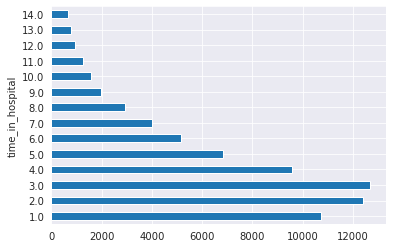

In [45]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6418
2.0     7534
3.0     7616
4.0     5705
5.0     4064
6.0     3026
7.0     2350
8.0     1800
9.0     1180
10.0     962
11.0     750
12.0     573
13.0     528
14.0     405
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


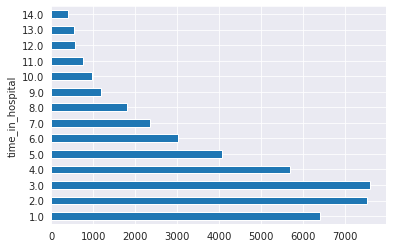

In [46]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2182
2.0     2450
3.0     2564
4.0     1942
5.0     1369
6.0     1055
7.0      824
8.0      535
9.0      380
10.0     300
11.0     243
12.0     197
13.0     137
14.0     125
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


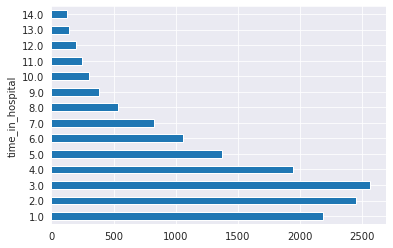

In [47]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

### Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    38025
Male      33490
nan           3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


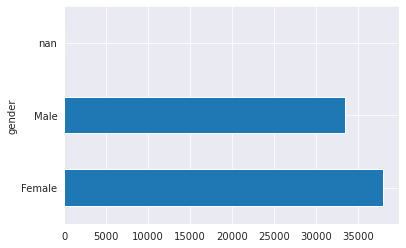

In [48]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby(
    'patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')


gender
Female    22850
Male      20061
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


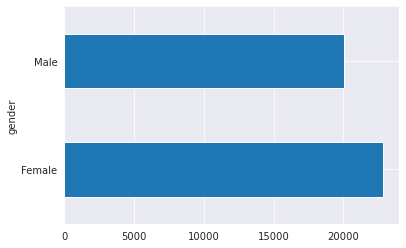

In [49]:
# Training partition
show_group_stats_viz(d_train, 'gender')


gender
Female    7590
Male      6710
nan          3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


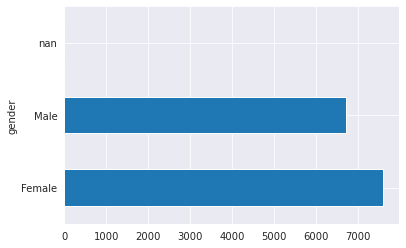

In [50]:
# Test partition
show_group_stats_viz(d_test, 'gender')


### Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [51]:
# Convert dataset from Pandas dataframes to TF dataset
batch_size = 128
diabetes_train_ds = df_to_dataset(
    d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(
    d_test, PREDICTOR_FIELD, batch_size=batch_size)


In [52]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]

def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))


## Create Features with TF Feature Columns

### Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [53]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)


In [54]:
vocab_file_list[0]


'./diabetes_vocab/admission_type_id_vocab.txt'

### Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [55]:
tf_cat_col_list = stu.create_tf_categorical_feature_cols(
    student_categorical_col_list, d_train)


INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 17 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 654 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 11526 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/

In [56]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.

### Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [57]:
from student_utils import create_tf_numeric_feature
import functools


In [58]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std


def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list


In [59]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [60]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)


Example continuous field:
NumericColumn(key='payer_code_bin', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f0872003200>, mean=0.046514879634592526, std=0.21059980815473528))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [ 4.527474  ]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]
 [-0.22086857]

## Build Model

### Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [61]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)


### Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.


In [62]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tfp.layers.DenseVariational(
            1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                              scale=1e-3 +
                                              tf.math.softplus(
                                                  0.01 * t[..., 1:])
                                              )
        ),
    ])
    return model


def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=30, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(
        lr=1e-3), loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor=loss_metric, patience=5)
    # reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor=loss_metric, factor=0.1,
    #                                                 patience=3, min_lr=1e-6)
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history


In [63]:
diabetes_model, history = build_diabetes_model(
    diabetes_train_ds, diabetes_val_ds, claim_feature_layer)


Train for 336 steps, validate for 112 steps
Epoch 1/30
336/336 [==============================] - 21s 64ms/step - loss: 25.2507 - mse: 25.0779 - val_loss: 19.6061 - val_mse: 19.1918
Epoch 2/30
336/336 [==============================] - 12s 36ms/step - loss: 17.7368 - mse: 17.2662 - val_loss: 15.8800 - val_mse: 15.2098
Epoch 3/30
336/336 [==============================] - 11s 34ms/step - loss: 13.6167 - mse: 12.8296 - val_loss: 11.6297 - val_mse: 10.7720
Epoch 4/30
336/336 [==============================] - 12s 36ms/step - loss: 11.7220 - mse: 10.8856 - val_loss: 11.7548 - val_mse: 10.9571
Epoch 5/30
336/336 [==============================] - 12s 37ms/step - loss: 10.9302 - mse: 10.1627 - val_loss: 9.9854 - val_mse: 8.9136
Epoch 6/30
336/336 [==============================] - 12s 37ms/step - loss: 10.2993 - mse: 9.4935 - val_loss: 8.9781 - val_mse: 7.9992
Epoch 7/30
336/336 [==============================] - 13s 38ms/step - loss: 9.5700 - mse: 8.7292 - val_loss: 8.2239 - val_mse: 7.3863

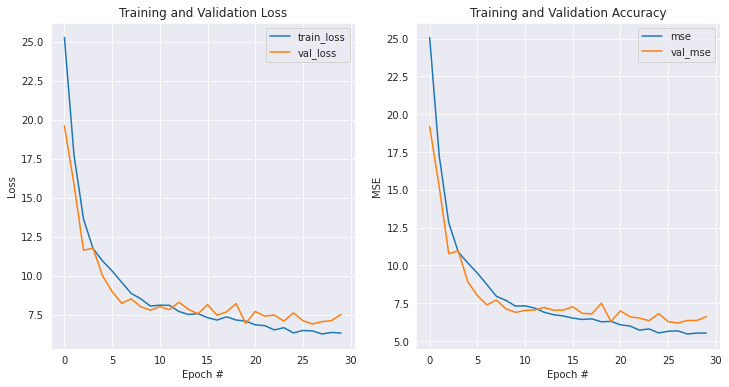

In [64]:
stu.plot_history(history)

## Process Model's Prediction Outputs

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below.

In [65]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)


In [66]:
m, s = stu.get_mean_std_from_preds(diabetes_yhat)


### Show Prediction Output 

In [67]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)


In [68]:
prob_output_df.head() 

,pred,actual_value,pred_mean,pred_std
0,1.847066,5.0,3.284983,0.703686
1,3.323271,5.0,3.160859,0.702637
2,2.606595,2.0,1.897070,0.701917
3,2.877123,5.0,4.805962,0.703693
4,2.800219,13.0,5.265440,0.705145


### Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [69]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(
    prob_output_df, 'pred_mean')


### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [70]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(
        lambda x: 1 if x >= 5 else 0)
    return test_df


pred_test_df = add_pred_to_test(
    d_test, student_binary_prediction, ['race', 'gender'])


In [71]:
ptd = pred_test_df[['patient_nbr', 'gender', 'race',
                    'time_in_hospital', 'score', 'label_value']]


In [72]:
a = DDM + num + ['score', 'label_value'] 

In [73]:
ptd = pred_test_df[a]

In [74]:
ptd[ptd['score']==1].head(10)

,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,other_diagnosis_codes,change,payer_code_bin,num_lab_procedures,number_diagnoses,num_medications,num_procedures,score,label_value
4,6,2,4,998,996|41,Ch,0.0,44,6,29,2,1,1
13,1,3,7,426,428|518,Ch,0.0,36,9,25,2,1,1
19,1,3,7,507,428|250.02,No,0.0,34,7,18,2,1,1
20,6,6,17,424,427|428,Ch,0.0,76,9,49,4,1,1
21,3,22,1,414,427|427,Ch,0.0,47,9,63,3,1,1
28,5,6,17,823,250.03|E880,Ch,0.0,17,6,15,3,1,0
29,1,1,7,250.22,276|788,Ch,0.0,72,8,15,3,1,1
34,1,1,7,577,574|535,No,0.0,56,9,13,4,1,0
36,1,6,7,162,491|553,No,0.0,42,9,23,1,1,0
38,2,1,1,410,285|250.01,Ch,0.0,75,6,33,6,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

**Answer**:    
Precision measures the model's ability to retrieve the relevant cases, while recall determines the model's ability to identify all relevant cases within a dataset.    

Based on the classification metrics, we can see that the trained model has 96% recall and 73% precision for the negative class, while it reaches 38% recall and 83% precision for the positive class. This means that, among 100 patients that will actually stay in hopital for no less than 5 days, the trained model can identify 38 out of them correctly. If we use the model to select 100 patients for the study, 83 patients are likely to stay in hospital for more than 5 days. 

In the future iterations, we need to improve the recall for positive cases because we expect the model to correctly identify all patients that satisfy the study requirements. 

In [75]:
from sklearn.metrics import brier_score_loss, f1_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score


In [76]:
labels = pred_test_df['label_value']
score = pred_test_df['score']

In [77]:
# AUC, F1, precision and recall
# Summary
class_report = classification_report(labels, score)
print(class_report)

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      9138
           1       0.83      0.38      0.52      5165

    accuracy                           0.75     14303
   macro avg       0.78      0.67      0.67     14303
weighted avg       0.77      0.75      0.72     14303



In [78]:
brier_score = brier_score_loss(labels, score)
print('Brier Score is {:.2f}'.format(brier_score))


Brier Score is 0.25


In [79]:
f1 = f1_score(labels, score, average='weighted')
print(f'F1 score: {f1}')

auroc = roc_auc_score(labels, score)
print(f'AUROC score: {auroc}')


F1 score: 0.7173629302637784
AUROC score: 0.6674647764078685


In [80]:
tn, fp, fn, tp = confusion_matrix(labels, (score > 0.5).astype(int)).ravel()
tn, fp, fn, tp


(8738, 400, 3209, 1956)

## Evaluating Potential Model Biases with Aequitas Toolkit

### Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [81]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


model_id, score_thresholds 1 {'rank_abs': [2356]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


### Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [82]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab,
                                        original_df=ae_df,
                                        ref_groups_dict={'race': 'Caucasian', 'gender': 'Male'
                                                         },
                                        alpha=0.05,
                                        check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)


get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

**Answer**:     
The model does not show a significant bias towards gender.    
`Asian` and `Other` groups are more likely to be correctly selected for the study, while the model has a significantly lower precision for predicting `Hispanic` patients. 

In [83]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?


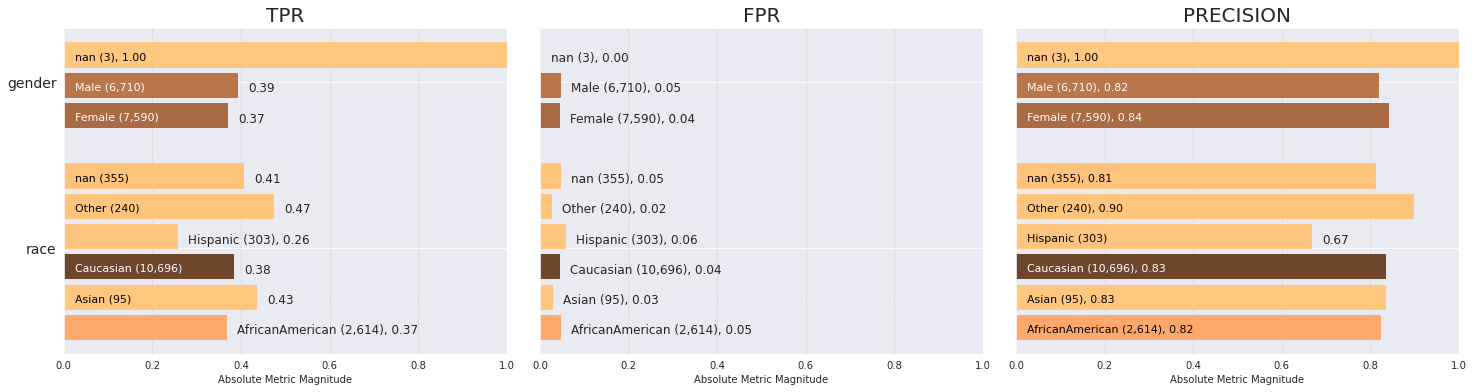

In [84]:
p = aqp.plot_group_metric_all(
    clean_xtab, metrics=['tpr', 'fpr', 'precision'], ncols=3)


## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

**Student Response**:    
From the fairness disparity analysis, we can see that `Asian` and `Other` groups have approximately the same amount of population as the `Hispanic` group in the dataset, the former ones have a much lower false positive rate, which indicates a large false positive rate disparity with regard to race. While for both gender groups, the false positive rates are fairly close. 

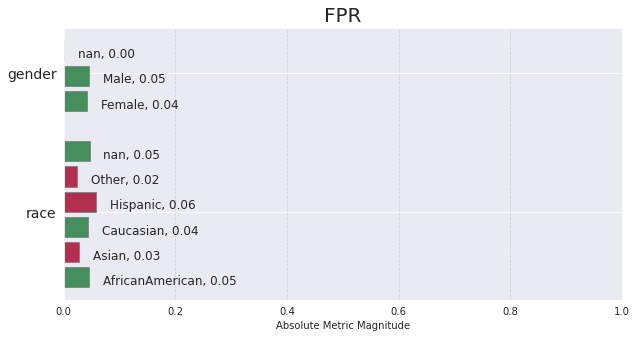

In [85]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)


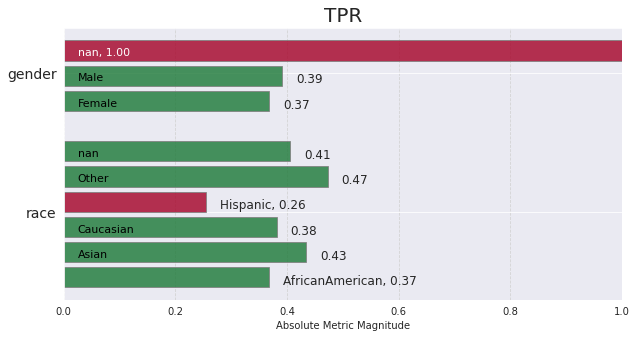

In [86]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)


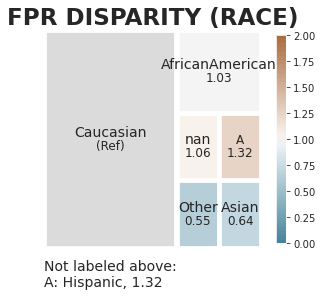

In [87]:
fpr_disparity_race = aqp.plot_disparity(bdf, group_metric='fpr_disparity',
                                        attribute_name='race')


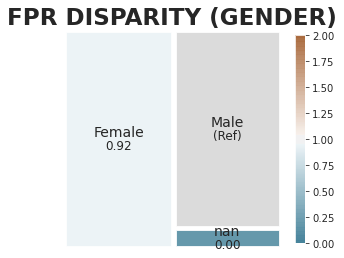

In [88]:
fpr_disparity_gender = aqp.plot_disparity(bdf, group_metric='fpr_disparity',
                                          attribute_name='gender')
